JAX implementation of a CNN, its training loop and evaluation on CIFAR-10 dataset.

Notes:
- we use categorical cross entropy
- also, we first train it serially, then we use pmap parallelism.

In [1]:
# @title Setup
import os

# Must be set before JAX/XLA init to partition host CPU for pmap testing.
# Re-run after restarting the runtime if you need to change this.
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf

# Keep TF's hands off the GPU memory; JAX is the primary compute engine here.
tf.config.set_visible_devices([], 'GPU')

def report_environment():
    backend = jax.default_backend()
    devices = jax.devices()

    print(f"JAX Backend: {backend.upper()}")
    print(f"Primary Devices: {len(devices)}")
    for d in devices:
        print(f" - {d.device_kind} (ID: {d.id})")

    if backend == 'gpu':
        print("\nHardware Driver Status:")
        # Direct check for driver/CUDA alignment
        try:
            !nvidia-smi --query-gpu=driver_version,compute_cap --format=csv,noheader
        except:
            print("nvidia-smi check failed.")

    print(f"\nSoftware Stack:")
    print(f" - JAX: {jax.__version__}")
    print(f" - Local Device Count: {jax.local_devices()}")

report_environment()

JAX Backend: GPU
Primary Devices: 1
 - Tesla T4 (ID: 0)

Hardware Driver Status:
550.54.15, 7.5

Software Stack:
 - JAX: 0.7.2
 - Local Device Count: [CudaDevice(id=0)]


In [2]:
# @title Data pipeline
import tensorflow_datasets as tfds

def load_cifar10(batch_size, train=True):
    split = 'train' if train else 'test'
    ds, info = tfds.load('cifar10', split=split, with_info=True, as_supervised=True)

    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        label = tf.one_hot(label, 10)
        return image, label

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        ds = ds.shuffle(10000).repeat()

    ds = ds.batch(batch_size, drop_remainder=True)
    # Ensure the host stays ahead of the accelerator.
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # Use as_numpy to avoid TF tensor overhead in JAX.
    return tfds.as_numpy(ds), info

# Initialize generators.
BATCH_SIZE = 64
train_ds_iterable, ds_info = load_cifar10(BATCH_SIZE, train=True)
test_ds_iterable, _ = load_cifar10(BATCH_SIZE, train=False)

# Create iterators for manual stepping.
train_ds = iter(train_ds_iterable)
test_ds = iter(test_ds_iterable)

# Verification.
sample_batch = next(train_ds)
print(f"Batch shapes: Images {sample_batch[0].shape}, Labels {sample_batch[1].shape}")
print(f"Data types:  Images {sample_batch[0].dtype}, Labels {sample_batch[1].dtype}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.DWKVXI_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.DWKVXI_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Batch shapes: Images (64, 32, 32, 3), Labels (64, 10)
Data types:  Images float32, Labels float32


In [3]:
# @title Model definition
import flax.linen as nn

class CIFAR10CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

model = CIFAR10CNN()
key = jax.random.PRNGKey(0)

# Initialize with a dummy input to fix parameter shapes.
variables = model.init(key, jnp.ones((1, 32, 32, 3)))
params = variables['params']

# Quick shape verification.
jax.tree_util.tree_map(lambda x: print(f"Layer shape: {x.shape}"), params)

Layer shape: (32,)
Layer shape: (3, 3, 3, 32)
Layer shape: (64,)
Layer shape: (3, 3, 32, 64)
Layer shape: (256,)
Layer shape: (4096, 256)
Layer shape: (10,)
Layer shape: (256, 10)


{'Conv_0': {'bias': None, 'kernel': None},
 'Conv_1': {'bias': None, 'kernel': None},
 'Dense_0': {'bias': None, 'kernel': None},
 'Dense_1': {'bias': None, 'kernel': None}}

In [4]:
# @title Loss and update logic

import optax

# Standard Adam optimizer setup.
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

def compute_loss(params, images, labels):
    """
    Computes cross-entropy loss between model logits and one-hot labels.
    """
    logits = model.apply({'params': params}, images)
    # Using the current optax API for categorical cross entropy.
    loss = optax.softmax_cross_entropy(logits=logits, labels=labels)
    return jnp.mean(loss)

@jax.jit
def train_step(params, opt_state, images, labels):
    """
    Fuses the gradient computation and parameter update into one XLA kernel.
    """
    # Calculate scalar loss and the gradients for the parameter Pytree.
    loss, grads = jax.value_and_grad(compute_loss)(params, images, labels)

    # Transform gradients into updates based on the optimizer state.
    updates, opt_state = optimizer.update(grads, opt_state, params)

    # Apply those updates to the current parameters.
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

# Single execution to trigger JIT compilation and verify the step.
params, opt_state, loss = train_step(params, opt_state, sample_batch[0], sample_batch[1])
print(f"Initial loss: {loss:.4f}")

Initial loss: 2.2915


In [5]:
# @title Training loop and evaluation

import time

def train_model(params, opt_state, dataset, num_steps=500):
    """
    Main training loop for CIFAR-10.
    """
    step_losses = []
    start_time = time.time()

    print(f"Starting training for {num_steps} steps...")

    for step in range(num_steps):
        # Pull the next pre-processed batch from the iterator.
        batch_images, batch_labels = next(dataset)

        # Execute the compiled train_step on the GPU.
        params, opt_state, loss = train_step(params, opt_state, batch_images, batch_labels)
        step_losses.append(loss)

        if step % 100 == 0:
            avg_loss = np.mean(step_losses[-100:])
            print(f"Step {step:4d} | Loss: {avg_loss:.4f}")

    end_time = time.time()
    total_time = end_time - start_time

    print(f"\nTraining complete.")
    print(f"Total time: {total_time:.2f}s | Speed: {num_steps/total_time:.2f} steps/s")

    return params, opt_state, step_losses

# Execute the training.
params, opt_state, history = train_model(params, opt_state, train_ds)

Starting training for 500 steps...
Step    0 | Loss: 2.5472
Step  100 | Loss: 1.8518
Step  200 | Loss: 1.4691
Step  300 | Loss: 1.3692
Step  400 | Loss: 1.2637

Training complete.
Total time: 5.21s | Speed: 95.90 steps/s


In [6]:
# @title Model evaluation

@jax.jit
def accuracy_step(params, images, labels):
    """
    Computes accuracy for a single batch.
    """
    logits = model.apply({'params': params}, images)
    # Get the index of the highest probability.
    predictions = jnp.argmax(logits, axis=-1)
    # Labels are one-hot, so we need the index there too.
    actual = jnp.argmax(labels, axis=-1)
    return jnp.mean(predictions == actual)

def evaluate_model(params, dataset, num_batches=10):
    """
    Runs the model over several test batches to estimate accuracy.
    """
    accs = []
    for _ in range(num_batches):
        batch_images, batch_labels = next(dataset)
        acc = accuracy_step(params, batch_images, batch_labels)
        accs.append(acc)

    return np.mean(accs)

# Check performance on the test set.
test_acc = evaluate_model(params, test_ds, num_batches=20)
print(f"Test Accuracy after 500 steps: {test_acc:.2%}")

Test Accuracy after 500 steps: 56.41%


In [7]:
# @title Parallel training logic
from functools import partial

# Initial replication of state across available silicon.
# Even for a single T4, using pmap now saves a refactor later when scaling.
replicated_params = jax.device_put_replicated(params, jax.local_devices())
replicated_opt_state = jax.device_put_replicated(opt_state, jax.local_devices())

@partial(jax.pmap, axis_name='batch')
def parallel_train_step(params, opt_state, images, labels):
    """
    Standard data-parallel update with pmean for gradient sync.
    """
    loss, grads = jax.value_and_grad(compute_loss)(params, images, labels)

    # Collective reduction across the specified axis.
    grads = jax.lax.pmean(grads, axis_name='batch')
    loss = jax.lax.pmean(loss, axis_name='batch')

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

def reshape_for_pmap(images, labels):
    """
    Manual sharding: splits global batch into [num_devices, local_batch, ...].
    """
    n_dev = jax.local_device_count()
    if images.shape[0] % n_dev != 0:
        raise ValueError(f"Batch size {images.shape[0]} not divisible by {n_dev} devices.")

    img_reshaped = images.reshape((n_dev, -1) + images.shape[1:])
    lbl_reshaped = labels.reshape((n_dev, -1) + labels.shape[1:])
    return img_reshaped, lbl_reshaped

# Smoke test for the parallel path.
batch_images, batch_labels = next(train_ds)
p_images, p_labels = reshape_for_pmap(batch_images, batch_labels)

replicated_params, replicated_opt_state, p_loss = parallel_train_step(
    replicated_params, replicated_opt_state, p_images, p_labels
)

# Extract first device's loss for verification.
print(f"Parallel step loss: {p_loss[0]:.4f}")

Parallel step loss: 1.0966


In [8]:
# @title Distributed training loop
import time

# Move parameters and optimizer state to accelerator memory.
# This ensures each device has its own local copy for the pmap operations.
replicated_params = jax.device_put_replicated(params, jax.local_devices())
replicated_opt_state = jax.device_put_replicated(opt_state, jax.local_devices())

def train_parallel(params, opt_state, dataset, num_steps=1000):
    """
    Executes parallel training across the device topology.
    """
    start_time = time.time()
    print(f"Executing parallel training for {num_steps} steps...")

    for step in range(num_steps):
        # Pull next global batch from host pipeline.
        batch_images, batch_labels = next(dataset)

        # Partition global batch into device-local shards.
        p_images, p_labels = reshape_for_pmap(batch_images, batch_labels)

        # Synchronized update across devices.
        params, opt_state, loss = parallel_train_step(
            params, opt_state, p_images, p_labels
        )

        if step % 200 == 0:
            # Report scalar loss from the lead device.
            print(f"Step {step:4d} | Multi-device Loss: {loss[0]:.4f}")

    total_time = time.time() - start_time
    print(f"\nParallel training complete.")
    print(f"Throughput: {num_steps/total_time:.2f} steps/s")

    return params, opt_state

# Run the optimized loop.
replicated_params, replicated_opt_state = train_parallel(
    replicated_params, replicated_opt_state, train_ds
)

Executing parallel training for 1000 steps...
Step    0 | Multi-device Loss: 1.1119
Step  200 | Multi-device Loss: 1.2619
Step  400 | Multi-device Loss: 0.9730
Step  600 | Multi-device Loss: 0.9734
Step  800 | Multi-device Loss: 0.8685

Parallel training complete.
Throughput: 213.04 steps/s


In [11]:
# @title Final evaluation

# Strip the device dimension to get back to a single-device parameter set.
final_params = jax.tree_util.tree_map(lambda x: x[0], replicated_params)

def evaluate_final(params, dataset, num_batches=50):
    """
    Final accuracy check on the test set.
    """
    accuracies = []
    for _ in range(num_batches):
        batch_images, batch_labels = next(dataset)
        # Use the compiled accuracy function.
        acc = accuracy_step(params, batch_images, batch_labels)
        accuracies.append(acc)
    return np.mean(accuracies)

final_accuracy = evaluate_final(final_params, test_ds)
print(f"Final Test Accuracy: {final_accuracy:.2%}")

Final Test Accuracy: 68.00%


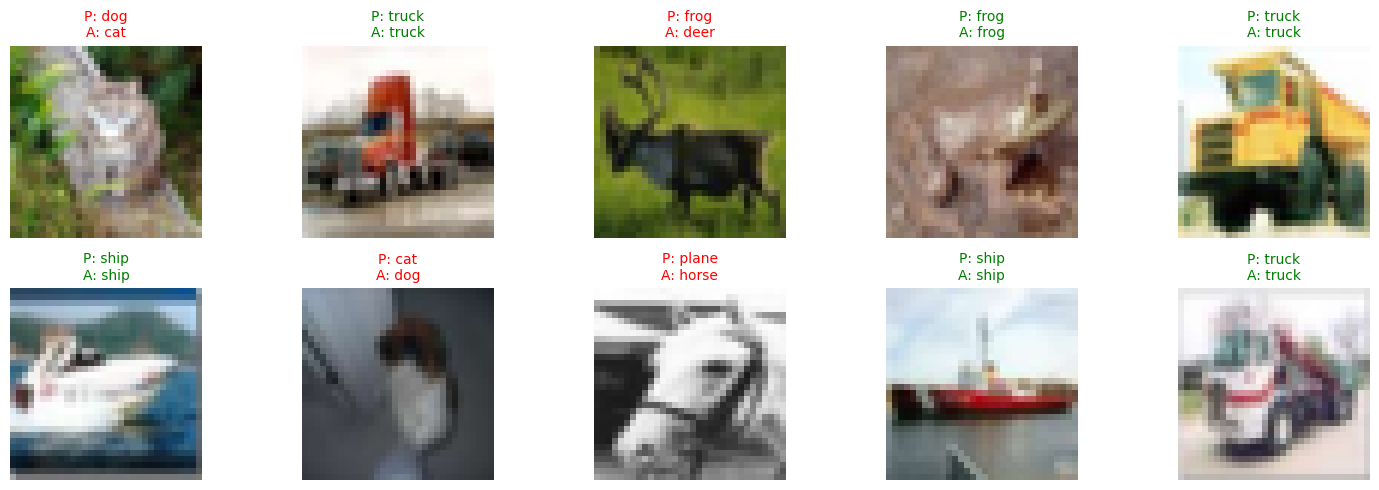

In [18]:
# @title Prediction visualization

import matplotlib.pyplot as plt

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

@jax.jit
def get_predictions(params, images):
    logits = model.apply({'params': params}, images)
    return jnp.argmax(logits, axis=-1)

def plot_predictions(params, images, labels, num_samples=10):
    # Process the whole slice at once.
    preds = get_predictions(params, images[:num_samples])
    actuals = jnp.argmax(labels[:num_samples], axis=-1)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])

        color = 'green' if preds[i] == actuals[i] else 'red'
        title = f"P: {class_names[preds[i]]}\nA: {class_names[actuals[i]]}"
        plt.title(title, color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Grab a batch and plot.
vis_images, vis_labels = next(test_ds)
plot_predictions(final_params, vis_images, vis_labels)